# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 23.02.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../autotalker")

In [3]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
import scib
import seaborn as sns

from autotalker.benchmarking import compute_benchmarking_metrics

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 48278), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


### 1.2 Define Parameters

In [4]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
spatial_key = "spatial"

In [5]:
cell_type_colors = {"Epiblast" : "#635547",
                    "Primitive Streak" : "#DABE99",
                    "Caudal epiblast" : "#9e6762",
                    "PGC" : "#FACB12",
                    "Anterior Primitive Streak" : "#c19f70",
                    "Notochord" : "#0F4A9C",
                    "Def. endoderm" : "#F397C0",
                    "Definitive endoderm" : "#F397C0",
                    "Gut" : "#EF5A9D",
                    "Gut tube" : "#EF5A9D",
                    "Nascent mesoderm" : "#C594BF",
                    "Mixed mesoderm" : "#DFCDE4",
                    "Intermediate mesoderm" : "#139992",
                    "Caudal Mesoderm" : "#3F84AA",
                    "Paraxial mesoderm" : "#8DB5CE",
                    "Somitic mesoderm" : "#005579",
                    "Pharyngeal mesoderm" : "#C9EBFB",
                    "Splanchnic mesoderm" : "#C9EBFB",
                    "Cardiomyocytes" : "#B51D8D",
                    "Allantois" : "#532C8A",
                    "ExE mesoderm" : "#8870ad",
                    "Lateral plate mesoderm" : "#8870ad",
                    "Mesenchyme" : "#cc7818",
                    "Mixed mesenchymal mesoderm" : "#cc7818",
                    "Haematoendothelial progenitors" : "#FBBE92",
                    "Endothelium" : "#ff891c",
                    "Blood progenitors 1" : "#f9decf",
                    "Blood progenitors 2" : "#c9a997",
                    "Erythroid1" : "#C72228",
                    "Erythroid2" : "#f79083",
                    "Erythroid3" : "#EF4E22",
                    "Erythroid" : "#f79083",
                    "Blood progenitors" : "#f9decf",
                    "NMP" : "#8EC792",
                    "Rostral neurectoderm" : "#65A83E",
                    "Caudal neurectoderm" : "#354E23",
                    "Neural crest" : "#C3C388",
                    "Forebrain/Midbrain/Hindbrain" : "#647a4f",
                    "Spinal cord" : "#CDE088",
                    "Surface ectoderm" : "#f7f79e",
                    "Visceral endoderm" : "#F6BFCB",
                    "ExE endoderm" : "#7F6874",
                    "ExE ectoderm" : "#989898",
                    "Parietal endoderm" : "#1A1A1A",
                    "Low quality" : "#e6e6e6",
                    "Cranial mesoderm" : "#77441B",
                    "Anterior somitic tissues" : "#F90026",
                    "Sclerotome" : "#A10037",
                    "Dermomyotome" : "#DA5921",
                    "Posterior somitic tissues" : "#E1C239",
                    "Presomitic mesoderm" : "#9DD84A",
                    "None" : "#D3D3D3"}

### 1.3 Run Notebook Setup

In [6]:
sc.set_figure_params(figsize=(6, 6))

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [8]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/{dataset}/method_benchmarking/comparison/{current_timestamp}"

In [9]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

### 1.5 Define Functions

In [10]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          cell_type_key,
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20]):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute Autotalker metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         active_gp_names_key=f"{model_name}_active_gp_names_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key=spatial_key,
                                                         spatial_knng_key=f"spatial_{n_neighbors}nng",
                                                         latent_knng_key=f"{model_name}_latent_{n_neighbors}nng_run{run_number}")

        # Compute scib metrics
        sc.pp.neighbors(adata=model_adata,
                        use_rep=f"{model_name}_latent_run{run_number}",
                        n_neighbors=n_neighbors)
        scib.me.cluster_optimal_resolution(adata=model_adata,
                                           cluster_key="cluster",
                                           label_key=cell_type_key)
        benchmarking_dict["ari"] = scib.me.ari(model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["clisi"] = scib.me.clisi_graph(adata=model_adata,
                                                         label_key=cell_type_key,
                                                         type_="embed",
                                                         use_rep=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["nmi"] = scib.me.nmi(adata=model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["asw"] = scib.me.silhouette(adata=model_adata,
                                                      label_key=cell_type_key,
                                                      embed=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["ilasw"] = scib.me.isolated_labels_asw(adata=model_adata,
                                                                 batch_key="sample",
                                                                 label_key=cell_type_key,
                                                                 embed=f"{model_name}_latent_run{run_number}")
        
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

## 2. Method Benchmarking

- Run all notebooks in the ```method_benchmarking``` directory before continuing.

### 3.1 Latent Space Comparison

#### 3.1.1 Define Function

In [11]:
def compute_latent_space_comparison(dataset,
                                    cell_type_key,
                                    n_neighbors=12,
                                    run_number=5):
    # Load data
    adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
    adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
    adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
    adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
    adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
    adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
    adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")
    
    adata_sagenet.obsm["X_umap"] = adata_sagenet.obsm[f"sagenet_latent_run{run_number}"] # latent representation of SageNet are already UMAP features
    for adata, method in zip([adata_pca, adata_scvi, adata_expimap, adata_deeplinc, adata_graphst, adata_autotalker],
                             ["pca", "scvi", "expimap", "deeplinc", "graphst", "autotalker"]):
        sc.pp.neighbors(adata,
                        use_rep=f"{method}_latent_run{run_number}",
                        n_neighbors=n_neighbors)
        sc.tl.umap(adata)
        
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    plt.suptitle("Latent Space Comparison", fontsize=25, x=0.575)
    plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.9)
    axs=axs.flatten()

    sc.pl.spatial(adata=adata,
                  color=[cell_type_key],
                  palette=cell_type_colors,
                  spot_size=0.03,
                  ax=axs[0],
                  show=False)
    axs[0].set_title("Physical Space", fontsize=17)
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(1.07, 0.845))
    axs[0].get_legend().remove()

    for i, (adata, title) in enumerate(zip([adata_autotalker, adata_deeplinc, adata_graphst, adata_sagenet, adata_pca, adata_scvi, adata_expimap],
                                           ["Autotalker", "DeepLinc", "GraphST", "SageNet", "Log Normalized Counts PCA", "scVI", "expiMap"])):        
        sc.pl.umap(adata,
                   color=[cell_type_key],
                   palette=cell_type_colors,
                   ax=axs[i + 1],
                   show=False,
                   legend_loc=None)
        axs[i + 1].set_title(title, fontsize=17)

    fig.savefig(f"{figure_folder_path}/latent_comparison.png",
                bbox_inches="tight")
    plt.show()

#### 3.1.2 Run Function

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages

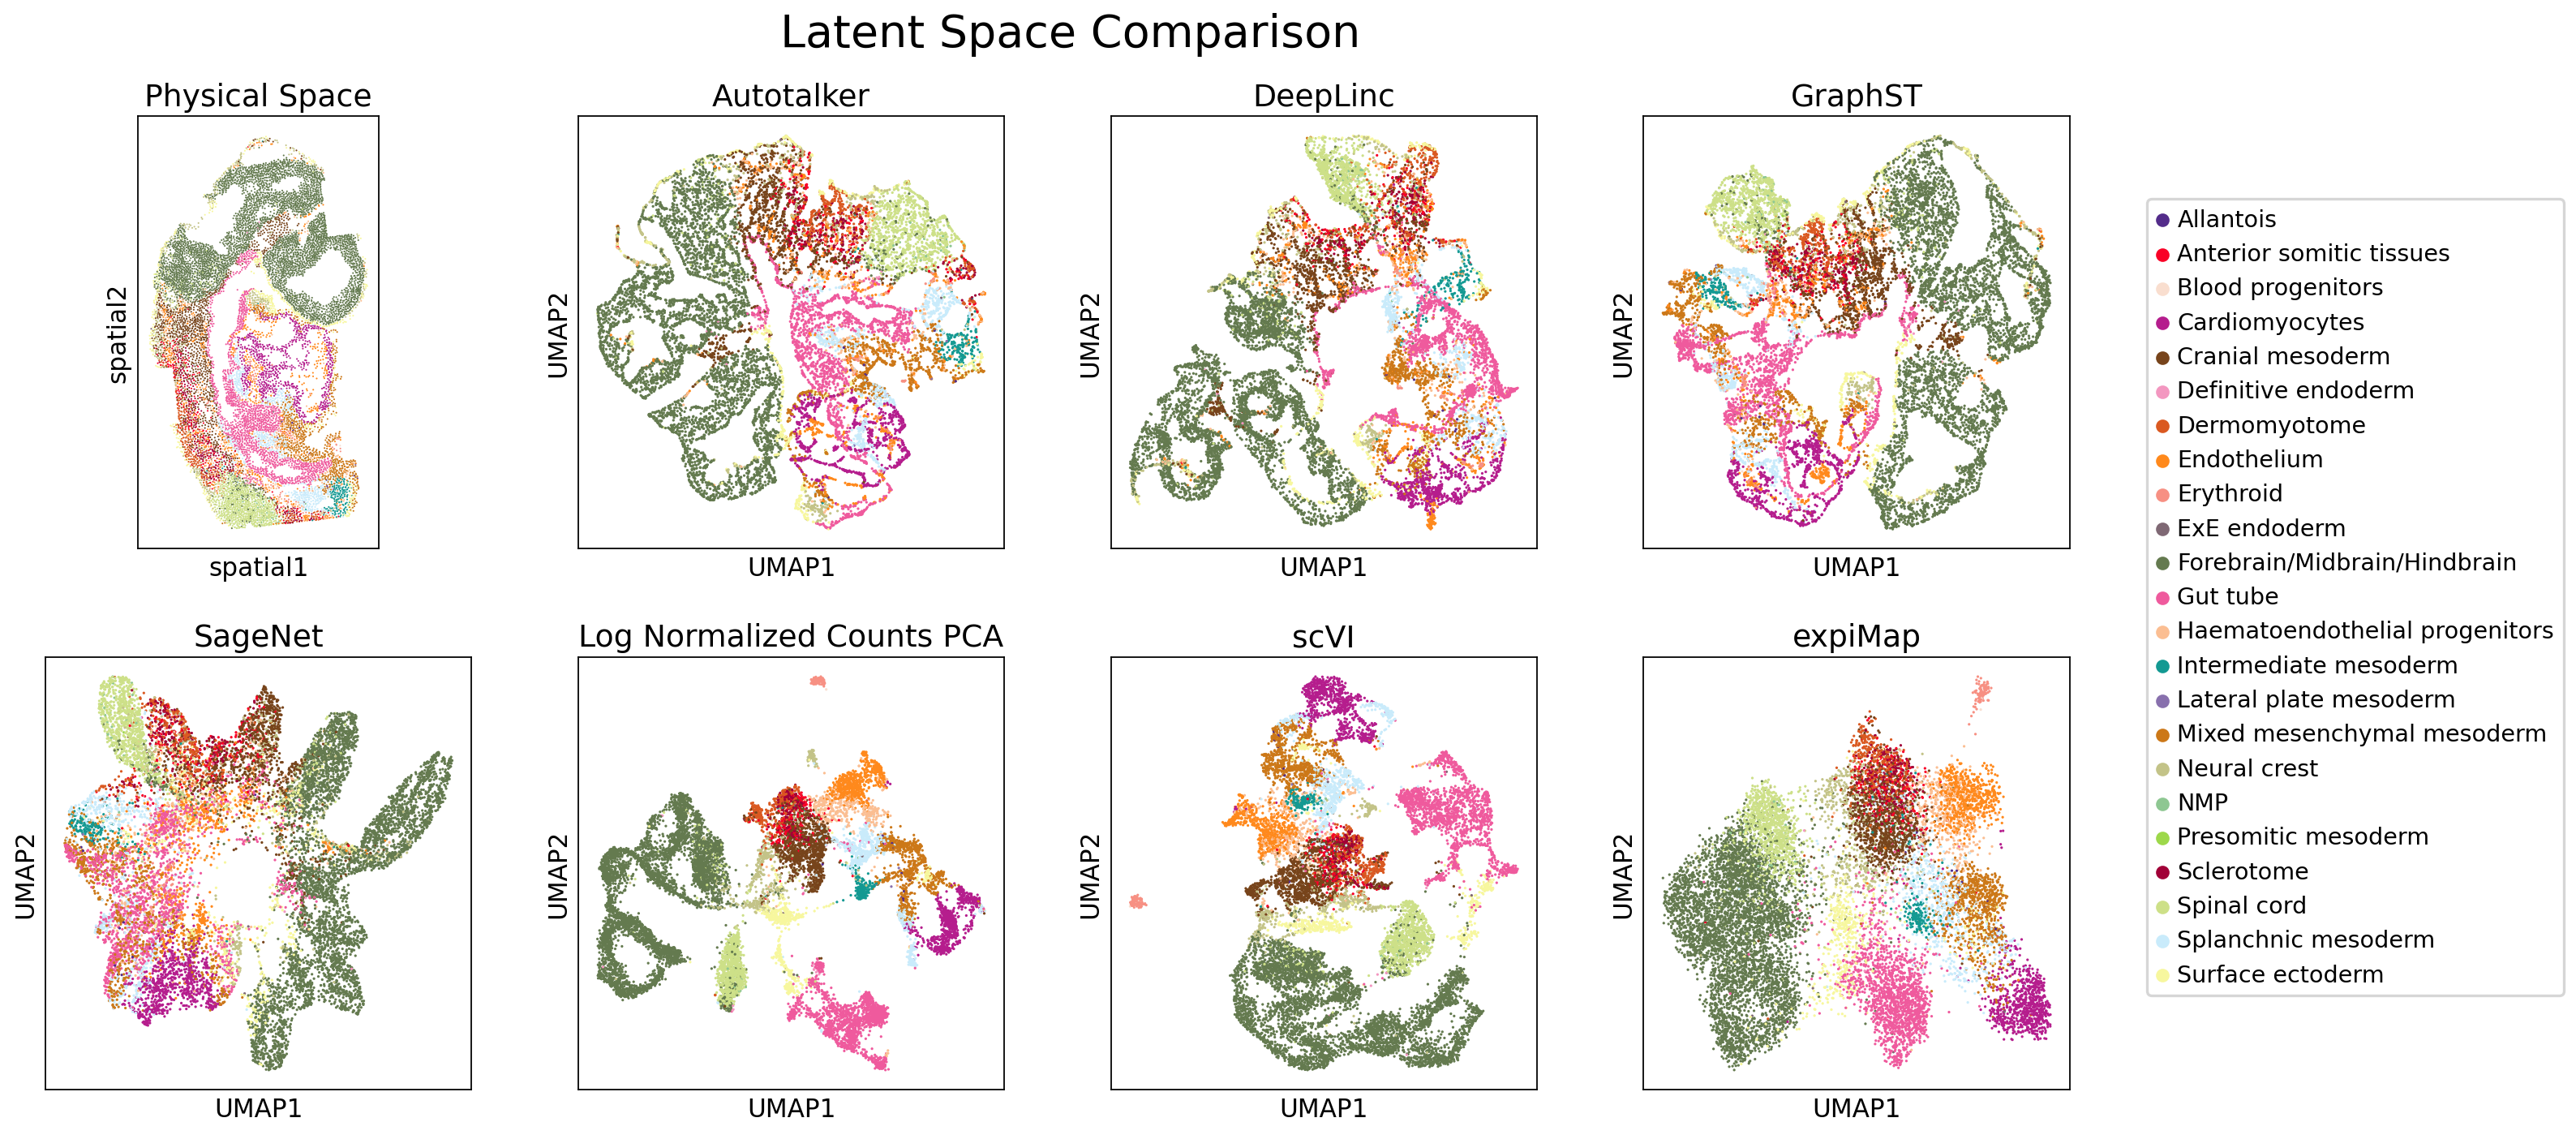

In [17]:
compute_latent_space_comparison(dataset="seqfish_mouse_organogenesis_embryo2",
                                cell_type_key="celltype_mapped_refined",
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="vizgen_merfish_mouse_liver",
                                cell_type_key="Cell_Type",
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns",
                                cell_type_key="Main_molecular_cell_type",
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc",
                                cell_type_key="cell_type",
                                n_neighbors=12,
                                run_number=5)

### 3.2 Benchmarking Metrics

#### 3.2.1 Define Functions

In [18]:
def compute_combined_benchmarking_metrics_for_all_models(dataset,
                                                         cell_type_key,
                                                         run_number_list=list(np.arange(1, 11)),
                                                         n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20]):
    # Configure dataset artifact folder path
    dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/{current_timestamp}"
    os.makedirs(dataset_artifact_folder_path, exist_ok=True)

    # PCA
    print("Computing metrics for PCA...")
    adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
    benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(model_adata=adata_pca,
                                                                       model_name="pca",
                                                                       run_number_list=run_number_list,
                                                                       n_neighbors_list=n_neighbors_list,
                                                                       cell_type_key=cell_type_key)   
    
    benchmarking_dict_list = benchmarking_dict_list_pca
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_pca)
    print("")
    
    # scVI
    print("Computing metrics for scVI...")
    adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
    benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(model_adata=adata_scvi,
                                                                        model_name="scvi",
                                                                        run_number_list=run_number_list,
                                                                        n_neighbors_list=n_neighbors_list,
                                                                        cell_type_key=cell_type_key)  
    benchmarking_dict_list += benchmarking_dict_list_scvi
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_scvi)
    print("")
    
    # expiMap
    print("Computing metrics for expiMap...")
    adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
    benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(model_adata=adata_expimap,
                                                                           model_name="expimap",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key)  
    benchmarking_dict_list += benchmarking_dict_list_expimap
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_expimap)
    print("")
    
    # SageNet
    print("Computing metrics for SageNet...")
    adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
    benchmarking_dict_list_sagenet = compute_combined_benchmarking_metrics(model_adata=adata_sagenet,
                                                                           model_name="sagenet",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key) 
    benchmarking_dict_list += benchmarking_dict_list_sagenet
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_sagenet)
    print("")
    
    # DeepLinc
    print("Computing metrics for DeepLinc...")
    adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
    benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(model_adata=adata_deeplinc,
                                                                            model_name="deeplinc",
                                                                            run_number_list=run_number_list,
                                                                            n_neighbors_list=n_neighbors_list,
                                                                            cell_type_key=cell_type_key)
    benchmarking_dict_list += benchmarking_dict_list_deeplinc
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_deeplinc)
    print("")
    
    # GraphST
    print("Computing metrics for GraphST...")
    adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
    benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(model_adata=adata_graphst,
                                                                           model_name="graphst",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key)
    benchmarking_dict_list += benchmarking_dict_list_graphst
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_graphst)
    print("")
    
    # Autotalker
    print("Computing metrics for Autotalker...")
    adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")
    benchmarking_dict_list_autotalker = compute_combined_benchmarking_metrics(model_adata=adata_autotalker,
                                                                              model_name="autotalker",
                                                                              run_number_list=run_number_list,
                                                                              n_neighbors_list=n_neighbors_list,
                                                                              cell_type_key=cell_type_key)
    benchmarking_dict_list += benchmarking_dict_list_autotalker
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_autotalker)
    print("")

In [ ]:
def create_summary_plot(dataset)
    # Read complete benchmarking data from disk
    with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
        benchmarking_dict_list = pickle.load(f)
        
    df = pd.DataFrame(benchmarking_dict_list)

#### 3.2.2 Run Functions

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="seqfish_mouse_organogenesis_embryo2",
                                                     cell_type_key="celltype_mapped_refined")

Computing metrics for PCA...
Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.7285822613987104
resolution: 0.2, nmi: 0.706069569178437
resolution: 0.3, nmi: 0.6681714801337553
resolution: 0.4, nmi: 0.6763604440499338
resolution: 0.5, nmi: 0.6646943696536569
resolution: 0.6, nmi: 0.6624165040420409
resolution: 0.7, nmi: 0.658723707593582
resolution: 0.8, nmi: 0.6561603682178326
resolution: 0.9, nmi: 0.651651840931409
resolution: 1.0, nmi: 0.6406839904485081
resolution: 1.1, nmi: 0.6433500290589333
resolution: 1.2, nmi: 0.6321319006297512
resolution: 1.3, nmi: 0.629589725719491
resolution: 1.4, nmi: 0.6308181670104738
resolution: 1.5, nmi: 0.6237388950857573
resolution: 1.6, nmi: 0.6245825483752583
resolution: 1.7, nmi: 0.6220446102237699
resolution: 1.8, nmi: 0.619965311531706
resolution: 1.9, nmi: 0.6190581212571481
resolution: 2.0, nmi: 0.6126859374078181
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.7153471378878755
resolution: 0.2, nmi: 0.6992890818342439
resolution: 0.3, nmi: 0.6670917830097711
resolution: 0.4, nmi: 0.6723606698196538
resolution: 0.5, nmi: 0.6647926522061692
resolution: 0.6, nmi: 0.6563709673291727
resolution: 0.7, nmi: 0.647163843376996
resolution: 0.8, nmi: 0.6527416672971577
resolution: 0.9, nmi: 0.6499778268497381
resolution: 1.0, nmi: 0.641623043833983
resolution: 1.1, nmi: 0.6427062345453814
resolution: 1.2, nmi: 0.6425759951452757
resolution: 1.3, nmi: 0.6355235187452952
resolution: 1.4, nmi: 0.629174203676689
resolution: 1.5, nmi: 0.6244514732111808
resolution: 1.6, nmi: 0.6203432767854427
resolution: 1.7, nmi: 0.6194221121371727
resolution: 1.8, nmi: 0.620102681095391
resolution: 1.9, nmi: 0.6173760294065923
resolution: 2.0, nmi: 0.6136605834297545
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6638656532474885
resolution: 0.2, nmi: 0.7091395789289606
resolution: 0.3, nmi: 0.7107519697846822
resolution: 0.4, nmi: 0.6962979413469914
resolution: 0.5, nmi: 0.675440824606218
resolution: 0.6, nmi: 0.6821063378278818
resolution: 0.7, nmi: 0.6686773228939339
resolution: 0.8, nmi: 0.6578611521045142
resolution: 0.9, nmi: 0.6515262283046769
resolution: 1.0, nmi: 0.6566464564330073
resolution: 1.1, nmi: 0.6637144727804832
resolution: 1.2, nmi: 0.6578398117213438
resolution: 1.3, nmi: 0.6527690322581248
resolution: 1.4, nmi: 0.6550892573751422
resolution: 1.5, nmi: 0.6508445008207986
resolution: 1.6, nmi: 0.647757824320906
resolution: 1.7, nmi: 0.6440284774689634
resolution: 1.8, nmi: 0.6384224602311696
resolution: 1.9, nmi: 0.6374792926364717
resolution: 2.0, nmi: 0.6338495331134266
optimised clustering against celltype_mapped_refined
optimal cluster resolution

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6638656532474885
resolution: 0.2, nmi: 0.7074653909142509
resolution: 0.3, nmi: 0.7040342991619252
resolution: 0.4, nmi: 0.6974831277090904
resolution: 0.5, nmi: 0.6736514847697812
resolution: 0.6, nmi: 0.6793592973467671
resolution: 0.7, nmi: 0.6696807299865092
resolution: 0.8, nmi: 0.6591607613668856
resolution: 0.9, nmi: 0.6536853671683235
resolution: 1.0, nmi: 0.6577276431453332
resolution: 1.1, nmi: 0.6595014277479889
resolution: 1.2, nmi: 0.6504109628761351
resolution: 1.3, nmi: 0.6558878064241682
resolution: 1.4, nmi: 0.655801885670099
resolution: 1.5, nmi: 0.6533750466733483
resolution: 1.6, nmi: 0.6465658237681333
resolution: 1.7, nmi: 0.6442606551364826
resolution: 1.8, nmi: 0.6370026503078411
resolution: 1.9, nmi: 0.6372235550706823
resolution: 2.0, nmi: 0.6321052818831518
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6671598966293653
resolution: 0.2, nmi: 0.7158968023911197
resolution: 0.3, nmi: 0.7054832149643439
resolution: 0.4, nmi: 0.7053387426965614
resolution: 0.5, nmi: 0.6790780235143196
resolution: 0.6, nmi: 0.6776521596227686
resolution: 0.7, nmi: 0.6679642642364211
resolution: 0.8, nmi: 0.6676204692054127
resolution: 0.9, nmi: 0.6711490723608667
resolution: 1.0, nmi: 0.6667573927379348
resolution: 1.1, nmi: 0.6580210214681536
resolution: 1.2, nmi: 0.6554796775377647
resolution: 1.3, nmi: 0.6555792910165441
resolution: 1.4, nmi: 0.6586600338615146
resolution: 1.5, nmi: 0.6526281827588307
resolution: 1.6, nmi: 0.6543868855556094
resolution: 1.7, nmi: 0.6505647332299199
resolution: 1.8, nmi: 0.6505781343522772
resolution: 1.9, nmi: 0.6499608635877406
resolution: 2.0, nmi: 0.6425678322659991
optimised clustering against celltype_mapped_refined
optimal cluster resoluti

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6679413663650948
resolution: 0.2, nmi: 0.7145550943779467
resolution: 0.3, nmi: 0.7072631178497022
resolution: 0.4, nmi: 0.704052583470106
resolution: 0.5, nmi: 0.6795924780388656
resolution: 0.6, nmi: 0.6849129713743666
resolution: 0.7, nmi: 0.671730930534024
resolution: 0.8, nmi: 0.6776412113954309
resolution: 0.9, nmi: 0.6695863340733968
resolution: 1.0, nmi: 0.6731700397503843
resolution: 1.1, nmi: 0.6587324827097943
resolution: 1.2, nmi: 0.6593337273242172
resolution: 1.3, nmi: 0.6552139374414966
resolution: 1.4, nmi: 0.655515624439957
resolution: 1.5, nmi: 0.6525565754431271
resolution: 1.6, nmi: 0.6545697597955981
resolution: 1.7, nmi: 0.6516760388590307
resolution: 1.8, nmi: 0.6515409433596011
resolution: 1.9, nmi: 0.6487374053115874
resolution: 2.0, nmi: 0.6434669293451836
optimised clustering against celltype_mapped_refined
optimal cluster resolution:

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6708847061076463
resolution: 0.2, nmi: 0.7397157424009787
resolution: 0.3, nmi: 0.7138442080238201
resolution: 0.4, nmi: 0.7042004061311
resolution: 0.5, nmi: 0.69904687701409
resolution: 0.6, nmi: 0.6805862511543597
resolution: 0.7, nmi: 0.6851834697704555
resolution: 0.8, nmi: 0.6736604652605866
resolution: 0.9, nmi: 0.6828692292291053
resolution: 1.0, nmi: 0.6769931360861292
resolution: 1.1, nmi: 0.6751628966730397
resolution: 1.2, nmi: 0.6681872676637575
resolution: 1.3, nmi: 0.6713149725133067
resolution: 1.4, nmi: 0.6601946197087754
resolution: 1.5, nmi: 0.6549887127085201
resolution: 1.6, nmi: 0.6538589685397386
resolution: 1.7, nmi: 0.6598900457984381
resolution: 1.8, nmi: 0.6516484014787786
resolution: 1.9, nmi: 0.6495583653265402
resolution: 2.0, nmi: 0.6491087282384572
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6705670528554006
resolution: 0.2, nmi: 0.7398010414429737
resolution: 0.3, nmi: 0.7136465267560169
resolution: 0.4, nmi: 0.7172558404544325
resolution: 0.5, nmi: 0.689962840213524
resolution: 0.6, nmi: 0.686911061132732
resolution: 0.7, nmi: 0.6858245997189313
resolution: 0.8, nmi: 0.6724330343222131
resolution: 0.9, nmi: 0.675253177400704
resolution: 1.0, nmi: 0.6794899559088996
resolution: 1.1, nmi: 0.6674836872006525
resolution: 1.2, nmi: 0.6624963309888605
resolution: 1.3, nmi: 0.6664232736318292
resolution: 1.4, nmi: 0.6580024137578572
resolution: 1.5, nmi: 0.6571350191243924
resolution: 1.6, nmi: 0.6542187894177721
resolution: 1.7, nmi: 0.6557307679368197
resolution: 1.8, nmi: 0.6499136155859013
resolution: 1.9, nmi: 0.6496233813737471
resolution: 2.0, nmi: 0.6513211650052976
optimised clustering against celltype_mapped_refined
optimal cluster resolution:

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.671075779895872
resolution: 0.2, nmi: 0.7412901423370858
resolution: 0.3, nmi: 0.7177550588080938
resolution: 0.4, nmi: 0.7170355498717439
resolution: 0.5, nmi: 0.7085411329621235
resolution: 0.6, nmi: 0.6929070431625898
resolution: 0.7, nmi: 0.6927411261001938
resolution: 0.8, nmi: 0.6793579318849983
resolution: 0.9, nmi: 0.6821854297101977
resolution: 1.0, nmi: 0.6773790512435577
resolution: 1.1, nmi: 0.6802996127084806
resolution: 1.2, nmi: 0.6727254353408968
resolution: 1.3, nmi: 0.660347810752322
resolution: 1.4, nmi: 0.6584740977844455
resolution: 1.5, nmi: 0.6582982786443183
resolution: 1.6, nmi: 0.6579868953343475
resolution: 1.7, nmi: 0.6540612097164628
resolution: 1.8, nmi: 0.6527493955363012
resolution: 1.9, nmi: 0.6541520236543403
resolution: 2.0, nmi: 0.6507548425223612
optimised clustering against celltype_mapped_refined
optimal cluster resolution

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6696978603931398
resolution: 0.2, nmi: 0.7291753674256918
resolution: 0.3, nmi: 0.7169799523417849
resolution: 0.4, nmi: 0.7141370700144212
resolution: 0.5, nmi: 0.6976555464899608
resolution: 0.6, nmi: 0.6928273174157177
resolution: 0.7, nmi: 0.6933373772433618
resolution: 0.8, nmi: 0.6702363760497365
resolution: 0.9, nmi: 0.6826161178033466
resolution: 1.0, nmi: 0.677228318992802
resolution: 1.1, nmi: 0.6702810859194441
resolution: 1.2, nmi: 0.6695032783811269
resolution: 1.3, nmi: 0.6603686340950158
resolution: 1.4, nmi: 0.6618001518119757
resolution: 1.5, nmi: 0.656770174267264
resolution: 1.6, nmi: 0.6574743827716037
resolution: 1.7, nmi: 0.6569023847335921
resolution: 1.8, nmi: 0.6542738339606882
resolution: 1.9, nmi: 0.6551641700024159
resolution: 2.0, nmi: 0.6503598765254595
optimised clustering against celltype_mapped_refined
optimal cluster resolution

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.685621411717674
resolution: 0.2, nmi: 0.6471899721304667
resolution: 0.3, nmi: 0.6485909687018613
resolution: 0.4, nmi: 0.6345303875561246
resolution: 0.5, nmi: 0.6342502430468097
resolution: 0.6, nmi: 0.6242204721919279
resolution: 0.7, nmi: 0.6227413212220767
resolution: 0.8, nmi: 0.6065731772208762
resolution: 0.9, nmi: 0.6128784009199278
resolution: 1.0, nmi: 0.6084284709237908
resolution: 1.1, nmi: 0.6005321159389975
resolution: 1.2, nmi: 0.5954276006988974
resolution: 1.3, nmi: 0.5915247268185205
resolution: 1.4, nmi: 0.5922456627835766
resolution: 1.5, nmi: 0.5891780025553703
resolution: 1.6, nmi: 0.5827425132069126
resolution: 1.7, nmi: 0.5810097721037915
resolution: 1.8, nmi: 0.5820231603474197
resolution: 1.9, nmi: 0.5749272802547902
resolution: 2.0, nmi: 0.5708759516800419
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6679324005602353
resolution: 0.2, nmi: 0.6526212463944956
resolution: 0.3, nmi: 0.6309607984516694
resolution: 0.4, nmi: 0.6284266561220452
resolution: 0.5, nmi: 0.6224383389724562
resolution: 0.6, nmi: 0.6232318427158705
resolution: 0.7, nmi: 0.6233386919639226
resolution: 0.8, nmi: 0.6104228768302493
resolution: 0.9, nmi: 0.6069933477745081
resolution: 1.0, nmi: 0.6005944207400971
resolution: 1.1, nmi: 0.6002020786766485
resolution: 1.2, nmi: 0.597143764260176
resolution: 1.3, nmi: 0.5961999607855978
resolution: 1.4, nmi: 0.5895739997746728
resolution: 1.5, nmi: 0.5829999481842172
resolution: 1.6, nmi: 0.5878324763218827
resolution: 1.7, nmi: 0.5804453197915614
resolution: 1.8, nmi: 0.5837769036774658
resolution: 1.9, nmi: 0.5730294664112423
resolution: 2.0, nmi: 0.5723767434264059
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6314595308599936
resolution: 0.2, nmi: 0.6846891390548739
resolution: 0.3, nmi: 0.6678313213619664
resolution: 0.4, nmi: 0.6530968153452119
resolution: 0.5, nmi: 0.651638782163164
resolution: 0.6, nmi: 0.6549237711284948
resolution: 0.7, nmi: 0.6544012326574218
resolution: 0.8, nmi: 0.6439544536492141
resolution: 0.9, nmi: 0.6432530474012274
resolution: 1.0, nmi: 0.6321337991433189
resolution: 1.1, nmi: 0.627765501387654
resolution: 1.2, nmi: 0.6250612496724564
resolution: 1.3, nmi: 0.6228401325737465
resolution: 1.4, nmi: 0.6126240709451789
resolution: 1.5, nmi: 0.6109822743580043
resolution: 1.6, nmi: 0.6080503803805989
resolution: 1.7, nmi: 0.6074856390779887
resolution: 1.8, nmi: 0.6074851678219878
resolution: 1.9, nmi: 0.6066458038377959
resolution: 2.0, nmi: 0.6049155637195532
optimised clustering against celltype_mapped_refined
optimal cluster resolution

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6837008731936718
resolution: 0.2, nmi: 0.6928450838422416
resolution: 0.3, nmi: 0.6739435470654661
resolution: 0.4, nmi: 0.6492402002363407
resolution: 0.5, nmi: 0.6472854089765341
resolution: 0.6, nmi: 0.6437149275081743
resolution: 0.7, nmi: 0.6341368469275906
resolution: 0.8, nmi: 0.627359975078022
resolution: 0.9, nmi: 0.6271669692037942
resolution: 1.0, nmi: 0.6336784175286377
resolution: 1.1, nmi: 0.6238644328072115
resolution: 1.2, nmi: 0.6169775675149596
resolution: 1.3, nmi: 0.6077183850705786
resolution: 1.4, nmi: 0.6243823038565991
resolution: 1.5, nmi: 0.6089472909233706
resolution: 1.6, nmi: 0.6100474161733109
resolution: 1.7, nmi: 0.6127105813115364
resolution: 1.8, nmi: 0.6030230493047615
resolution: 1.9, nmi: 0.6092672622417609
resolution: 2.0, nmi: 0.5989220360727878
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6561502523398804
resolution: 0.2, nmi: 0.6968626104795548
resolution: 0.3, nmi: 0.6672613035833
resolution: 0.4, nmi: 0.6661868627624039
resolution: 0.5, nmi: 0.6625249659196166
resolution: 0.6, nmi: 0.6538502817531038
resolution: 0.7, nmi: 0.6462043205010196
resolution: 0.8, nmi: 0.6486956086400679
resolution: 0.9, nmi: 0.6460301216712554
resolution: 1.0, nmi: 0.6443936994601157
resolution: 1.1, nmi: 0.6355066998879427
resolution: 1.2, nmi: 0.6397968153942373
resolution: 1.3, nmi: 0.6263216943247528
resolution: 1.4, nmi: 0.6364090046612189
resolution: 1.5, nmi: 0.6277554561283859
resolution: 1.6, nmi: 0.6200162667155963
resolution: 1.7, nmi: 0.6201908811939916
resolution: 1.8, nmi: 0.6214380502728616
resolution: 1.9, nmi: 0.6148939458311653
resolution: 2.0, nmi: 0.6152184572100444
optimised clustering against celltype_mapped_refined
optimal cluster resolution:

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6528119658955529
resolution: 0.2, nmi: 0.6857681127524047
resolution: 0.3, nmi: 0.6938527502192073
resolution: 0.4, nmi: 0.6532599944606468
resolution: 0.5, nmi: 0.6514324737603572
resolution: 0.6, nmi: 0.6493434069061228
resolution: 0.7, nmi: 0.6516263906175344
resolution: 0.8, nmi: 0.6529451110472343
resolution: 0.9, nmi: 0.6516965126353357
resolution: 1.0, nmi: 0.6396391555391703
resolution: 1.1, nmi: 0.6412377708868273
resolution: 1.2, nmi: 0.6311788900357478
resolution: 1.3, nmi: 0.6323267918066878
resolution: 1.4, nmi: 0.6368105438855797
resolution: 1.5, nmi: 0.6225399883967315
resolution: 1.6, nmi: 0.6286166897899718
resolution: 1.7, nmi: 0.6215089354362603
resolution: 1.8, nmi: 0.624432830029174
resolution: 1.9, nmi: 0.611368862841432
resolution: 2.0, nmi: 0.6066919383112305
optimised clustering against celltype_mapped_refined
optimal cluster resolution

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6598327310550504
resolution: 0.2, nmi: 0.6607426549769899
resolution: 0.3, nmi: 0.7038592969332375
resolution: 0.4, nmi: 0.6806676916899617
resolution: 0.5, nmi: 0.6782330636180869
resolution: 0.6, nmi: 0.6661859259849877
resolution: 0.7, nmi: 0.6577379898701894
resolution: 0.8, nmi: 0.6524669318572105
resolution: 0.9, nmi: 0.641665465978559
resolution: 1.0, nmi: 0.6369835877347909
resolution: 1.1, nmi: 0.6429221215984788
resolution: 1.2, nmi: 0.6418649785347791
resolution: 1.3, nmi: 0.6321726153510487
resolution: 1.4, nmi: 0.6408683660124219
resolution: 1.5, nmi: 0.6281402645731148
resolution: 1.6, nmi: 0.6247185026691046
resolution: 1.7, nmi: 0.6187508454716286
resolution: 1.8, nmi: 0.6135721775902689
resolution: 1.9, nmi: 0.6083910097696602
resolution: 2.0, nmi: 0.6062829668308839
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6477873010581136
resolution: 0.2, nmi: 0.6750740764508459
resolution: 0.3, nmi: 0.687993257415572
resolution: 0.4, nmi: 0.6589820339795565
resolution: 0.5, nmi: 0.6559138131627812
resolution: 0.6, nmi: 0.6332275005829172
resolution: 0.7, nmi: 0.6475073231364561
resolution: 0.8, nmi: 0.6448034720837009
resolution: 0.9, nmi: 0.6524852288670031
resolution: 1.0, nmi: 0.6412295590252052
resolution: 1.1, nmi: 0.6350318145250017
resolution: 1.2, nmi: 0.6343419850462821
resolution: 1.3, nmi: 0.6310383462022604
resolution: 1.4, nmi: 0.6289486145781924
resolution: 1.5, nmi: 0.6234888774764916
resolution: 1.6, nmi: 0.6233760729129448
resolution: 1.7, nmi: 0.6230158888261299
resolution: 1.8, nmi: 0.621830777068299
resolution: 1.9, nmi: 0.6188683485386909
resolution: 2.0, nmi: 0.6148901357439931
optimised clustering against celltype_mapped_refined
optimal cluster resolution

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6421212614432894
resolution: 0.2, nmi: 0.6493766570119212
resolution: 0.3, nmi: 0.6826840817611894
resolution: 0.4, nmi: 0.6505967145657714
resolution: 0.5, nmi: 0.6466776735910369
resolution: 0.6, nmi: 0.6538481104409704
resolution: 0.7, nmi: 0.6461619123023478
resolution: 0.8, nmi: 0.6451822286279971
resolution: 0.9, nmi: 0.6516705401224068
resolution: 1.0, nmi: 0.6425819097649953
resolution: 1.1, nmi: 0.6347499764540715
resolution: 1.2, nmi: 0.6380280099428313
resolution: 1.3, nmi: 0.6235174533544126
resolution: 1.4, nmi: 0.6275199869597359
resolution: 1.5, nmi: 0.6216268391892533
resolution: 1.6, nmi: 0.6196076934011214
resolution: 1.7, nmi: 0.6155595733165615
resolution: 1.8, nmi: 0.6112406612247093
resolution: 1.9, nmi: 0.6093458604484603
resolution: 2.0, nmi: 0.607756466281435
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.6448608018637443
resolution: 0.2, nmi: 0.6692225989284909
resolution: 0.3, nmi: 0.6818411671477975
resolution: 0.4, nmi: 0.664442408939769
resolution: 0.5, nmi: 0.6506056070416082
resolution: 0.6, nmi: 0.655248586380463
resolution: 0.7, nmi: 0.6570656975385246
resolution: 0.8, nmi: 0.6530989055691925
resolution: 0.9, nmi: 0.6473145964366392
resolution: 1.0, nmi: 0.6354240142938085
resolution: 1.1, nmi: 0.6326542556826341
resolution: 1.2, nmi: 0.6315616031508073
resolution: 1.3, nmi: 0.634268146727124
resolution: 1.4, nmi: 0.6254220750872297
resolution: 1.5, nmi: 0.6227197886007294
resolution: 1.6, nmi: 0.6248994743448505
resolution: 1.7, nmi: 0.6208056495295804
resolution: 1.8, nmi: 0.6185152856696574
resolution: 1.9, nmi: 0.6151782376132282
resolution: 2.0, nmi: 0.6080511312832266
optimised clustering against celltype_mapped_refined
optimal cluster resolution:

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.36478580424012863
resolution: 0.2, nmi: 0.545033101087256
resolution: 0.3, nmi: 0.590300784206925
resolution: 0.4, nmi: 0.5590945720765669
resolution: 0.5, nmi: 0.5586104819204905
resolution: 0.6, nmi: 0.5533421830742157
resolution: 0.7, nmi: 0.552831997737178
resolution: 0.8, nmi: 0.5503550046732495
resolution: 0.9, nmi: 0.5381181012485503
resolution: 1.0, nmi: 0.5329694877098932
resolution: 1.1, nmi: 0.5289629782421417
resolution: 1.2, nmi: 0.5224794652920706
resolution: 1.3, nmi: 0.5127902415248418
resolution: 1.4, nmi: 0.5020942854046128
resolution: 1.5, nmi: 0.48822270211344343
resolution: 1.6, nmi: 0.48598945374742913
resolution: 1.7, nmi: 0.47911686624537175
resolution: 1.8, nmi: 0.4783716900975957
resolution: 1.9, nmi: 0.4717760200569709
resolution: 2.0, nmi: 0.4638357706787528
optimised clustering against celltype_mapped_refined
optimal cluster resolut

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.43097919731114465
resolution: 0.2, nmi: 0.544604246875093
resolution: 0.3, nmi: 0.5710317868158546
resolution: 0.4, nmi: 0.5694827626347897
resolution: 0.5, nmi: 0.5750150481841183
resolution: 0.6, nmi: 0.5746457951860815
resolution: 0.7, nmi: 0.5525909507702503
resolution: 0.8, nmi: 0.5400581191550987
resolution: 0.9, nmi: 0.535310282141021
resolution: 1.0, nmi: 0.5295451073552159
resolution: 1.1, nmi: 0.5156203320261953
resolution: 1.2, nmi: 0.5130732112220804
resolution: 1.3, nmi: 0.5080204644742402
resolution: 1.4, nmi: 0.5032561240374751
resolution: 1.5, nmi: 0.49726231919250385
resolution: 1.6, nmi: 0.48844718718628033
resolution: 1.7, nmi: 0.47631458919064523
resolution: 1.8, nmi: 0.46709635743615596
resolution: 1.9, nmi: 0.4610920956179788
resolution: 2.0, nmi: 0.4618746143378551
optimised clustering against celltype_mapped_refined
optimal cluster resol

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.39923228226676294
resolution: 0.2, nmi: 0.5814742650505094
resolution: 0.3, nmi: 0.6203578961713446
resolution: 0.4, nmi: 0.6456650370434508
resolution: 0.5, nmi: 0.6941266301220601
resolution: 0.6, nmi: 0.6563631900447399
resolution: 0.7, nmi: 0.6349549595957501
resolution: 0.8, nmi: 0.6364039332453245
resolution: 0.9, nmi: 0.6427192051019069
resolution: 1.0, nmi: 0.6428533003737096
resolution: 1.1, nmi: 0.6434996440167964
resolution: 1.2, nmi: 0.6460319613102656
resolution: 1.3, nmi: 0.6422777062531838
resolution: 1.4, nmi: 0.6439991835310861
resolution: 1.5, nmi: 0.6379347506182735
resolution: 1.6, nmi: 0.6385410070874065
resolution: 1.7, nmi: 0.6367356156789027
resolution: 1.8, nmi: 0.627951558596679
resolution: 1.9, nmi: 0.6196800177750286
resolution: 2.0, nmi: 0.620791701982098
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42108700241989533
resolution: 0.2, nmi: 0.582674048537967
resolution: 0.3, nmi: 0.6159890531549822
resolution: 0.4, nmi: 0.6399028137867437
resolution: 0.5, nmi: 0.616682908342825
resolution: 0.6, nmi: 0.6111361783714121
resolution: 0.7, nmi: 0.665445994464087
resolution: 0.8, nmi: 0.6632658304363717
resolution: 0.9, nmi: 0.6629479764271772
resolution: 1.0, nmi: 0.6635350223527907
resolution: 1.1, nmi: 0.6410557675317079
resolution: 1.2, nmi: 0.6403254370291961
resolution: 1.3, nmi: 0.6408366611007686
resolution: 1.4, nmi: 0.635295914895271
resolution: 1.5, nmi: 0.6349723590096981
resolution: 1.6, nmi: 0.6255697012221149
resolution: 1.7, nmi: 0.6153953059291828
resolution: 1.8, nmi: 0.6129089199353507
resolution: 1.9, nmi: 0.6030152045832876
resolution: 2.0, nmi: 0.60132468608839
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4100495036600698
resolution: 0.2, nmi: 0.5617522480336046
resolution: 0.3, nmi: 0.6296900151153592
resolution: 0.4, nmi: 0.6293511899534623
resolution: 0.5, nmi: 0.6495577422915542
resolution: 0.6, nmi: 0.6244137516276306
resolution: 0.7, nmi: 0.621432603424025
resolution: 0.8, nmi: 0.6578760952268784
resolution: 0.9, nmi: 0.6581658157140494
resolution: 1.0, nmi: 0.64205343527747
resolution: 1.1, nmi: 0.6743817149829363
resolution: 1.2, nmi: 0.6481914034382756
resolution: 1.3, nmi: 0.6547668705279018
resolution: 1.4, nmi: 0.6438240092671746
resolution: 1.5, nmi: 0.6582673031596199
resolution: 1.6, nmi: 0.6599371521481844
resolution: 1.7, nmi: 0.6466195482935707
resolution: 1.8, nmi: 0.6388424917336337
resolution: 1.9, nmi: 0.6302957590573603
resolution: 2.0, nmi: 0.6313517236096424
optimised clustering against celltype_mapped_refined
optimal cluster resolution:

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.39857479039321214
resolution: 0.2, nmi: 0.5950102816565586
resolution: 0.3, nmi: 0.6073055961086717
resolution: 0.4, nmi: 0.6334494921270086
resolution: 0.5, nmi: 0.634855397008705
resolution: 0.6, nmi: 0.6547516387852862
resolution: 0.7, nmi: 0.6554422284494625
resolution: 0.8, nmi: 0.6511600573864429
resolution: 0.9, nmi: 0.6753915992927513
resolution: 1.0, nmi: 0.6803447928730141
resolution: 1.1, nmi: 0.6660657244066364
resolution: 1.2, nmi: 0.6688848147559111
resolution: 1.3, nmi: 0.6664489546664952
resolution: 1.4, nmi: 0.6673208055775733
resolution: 1.5, nmi: 0.6651026938565247
resolution: 1.6, nmi: 0.6608270138806515
resolution: 1.7, nmi: 0.6561927609124104
resolution: 1.8, nmi: 0.6565132649150139
resolution: 1.9, nmi: 0.657378368359065
resolution: 2.0, nmi: 0.6468358740894445
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.40877732605985784
resolution: 0.2, nmi: 0.42792181480502905
resolution: 0.3, nmi: 0.6366044838461268
resolution: 0.4, nmi: 0.6380864394314665
resolution: 0.5, nmi: 0.6394036142522608
resolution: 0.6, nmi: 0.6980843956794408
resolution: 0.7, nmi: 0.6934977337774335
resolution: 0.8, nmi: 0.678998559104652
resolution: 0.9, nmi: 0.6770853410698768
resolution: 1.0, nmi: 0.6552381231851938
resolution: 1.1, nmi: 0.6557623728346551
resolution: 1.2, nmi: 0.6649529636013424
resolution: 1.3, nmi: 0.6645539860881943
resolution: 1.4, nmi: 0.6627594630820902
resolution: 1.5, nmi: 0.6702220517142627
resolution: 1.6, nmi: 0.6660722199888431
resolution: 1.7, nmi: 0.6688356095577763
resolution: 1.8, nmi: 0.667933151025734
resolution: 1.9, nmi: 0.6586961805726573
resolution: 2.0, nmi: 0.6503715445222292
optimised clustering against celltype_mapped_refined
optimal cluster resoluti

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.40251618136726963
resolution: 0.2, nmi: 0.5352331673016175
resolution: 0.3, nmi: 0.6331043855080764
resolution: 0.4, nmi: 0.6369575860747145
resolution: 0.5, nmi: 0.6664566473267949
resolution: 0.6, nmi: 0.6685929116670827
resolution: 0.7, nmi: 0.654403082340288
resolution: 0.8, nmi: 0.6811465076132502
resolution: 0.9, nmi: 0.6766507040515904
resolution: 1.0, nmi: 0.6806512269443942
resolution: 1.1, nmi: 0.6781597791752324
resolution: 1.2, nmi: 0.6591542691090185
resolution: 1.3, nmi: 0.6463301657099014
resolution: 1.4, nmi: 0.6466465358695551
resolution: 1.5, nmi: 0.6548675093587366
resolution: 1.6, nmi: 0.6518847803703789
resolution: 1.7, nmi: 0.6519453456661755
resolution: 1.8, nmi: 0.646222426372409
resolution: 1.9, nmi: 0.6438173018920942
resolution: 2.0, nmi: 0.6481100216648451
optimised clustering against celltype_mapped_refined
optimal cluster resolutio

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.0
resolution: 0.2, nmi: 0.4095328233369642
resolution: 0.3, nmi: 0.6215917289616439
resolution: 0.4, nmi: 0.624495603935383
resolution: 0.5, nmi: 0.6240961274336453
resolution: 0.6, nmi: 0.6677963668247272
resolution: 0.7, nmi: 0.6891050618398017
resolution: 0.8, nmi: 0.6563496044243012
resolution: 0.9, nmi: 0.6484915651835318
resolution: 1.0, nmi: 0.6472078924434839
resolution: 1.1, nmi: 0.6534027699058371
resolution: 1.2, nmi: 0.6634292647519661
resolution: 1.3, nmi: 0.6436748352423891
resolution: 1.4, nmi: 0.6441858989382836
resolution: 1.5, nmi: 0.6510204648898453
resolution: 1.6, nmi: 0.6528966399201055
resolution: 1.7, nmi: 0.6400997950372936
resolution: 1.8, nmi: 0.6376326141323323
resolution: 1.9, nmi: 0.6374899046855532
resolution: 2.0, nmi: 0.6377352940082728
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.7
optimal 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.41769356764201604
resolution: 0.2, nmi: 0.5438289536042856
resolution: 0.3, nmi: 0.5984824406886058
resolution: 0.4, nmi: 0.6276736851884979
resolution: 0.5, nmi: 0.6399693583284568
resolution: 0.6, nmi: 0.6693183316410075
resolution: 0.7, nmi: 0.6674142860844732
resolution: 0.8, nmi: 0.6663486052121558
resolution: 0.9, nmi: 0.6909424915962313
resolution: 1.0, nmi: 0.6896914322615821
resolution: 1.1, nmi: 0.6749036536373925
resolution: 1.2, nmi: 0.6705982758554782
resolution: 1.3, nmi: 0.6491219676120914
resolution: 1.4, nmi: 0.6754132328644558
resolution: 1.5, nmi: 0.6563612983799644
resolution: 1.6, nmi: 0.6408474644432377
resolution: 1.7, nmi: 0.656296480156758
resolution: 1.8, nmi: 0.6576546445946564
resolution: 1.9, nmi: 0.6552094374774483
resolution: 2.0, nmi: 0.6466878142675679
optimised clustering against celltype_mapped_refined
optimal cluster resoluti

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4045086381505752
resolution: 0.2, nmi: 0.4015490118110005
resolution: 0.3, nmi: 0.4017096931497451
resolution: 0.4, nmi: 0.3966413598456475
resolution: 0.5, nmi: 0.39487992683842604
resolution: 0.6, nmi: 0.39429106915316653
resolution: 0.7, nmi: 0.3880191866250496
resolution: 0.8, nmi: 0.39067464232745885
resolution: 0.9, nmi: 0.3910951373870709
resolution: 1.0, nmi: 0.3909296480193628
resolution: 1.1, nmi: 0.3905224099549329
resolution: 1.2, nmi: 0.3878707091462998
resolution: 1.3, nmi: 0.38801490998830407
resolution: 1.4, nmi: 0.38811261037292943
resolution: 1.5, nmi: 0.38678693613128184
resolution: 1.6, nmi: 0.3850858678378868
resolution: 1.7, nmi: 0.3856112539038705
resolution: 1.8, nmi: 0.38507233599831553
resolution: 1.9, nmi: 0.3834406607465174
resolution: 2.0, nmi: 0.3839933864662823
optimised clustering against celltype_mapped_refined
optimal cluster r

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4067537790643961
resolution: 0.2, nmi: 0.39697830623359265
resolution: 0.3, nmi: 0.3948903275968966
resolution: 0.4, nmi: 0.39414083317365833
resolution: 0.5, nmi: 0.3929806926131513
resolution: 0.6, nmi: 0.3900451910315114
resolution: 0.7, nmi: 0.38866731321519715
resolution: 0.8, nmi: 0.38612071370790674
resolution: 0.9, nmi: 0.3846001377961614
resolution: 1.0, nmi: 0.3834782445390068
resolution: 1.1, nmi: 0.38264400253053094
resolution: 1.2, nmi: 0.3829407803752493
resolution: 1.3, nmi: 0.38118135411953336
resolution: 1.4, nmi: 0.3809966563791057
resolution: 1.5, nmi: 0.3802203288433148
resolution: 1.6, nmi: 0.3803190184702126
resolution: 1.7, nmi: 0.37958480330211586
resolution: 1.8, nmi: 0.3791385702618319
resolution: 1.9, nmi: 0.3787938236697775
resolution: 2.0, nmi: 0.3797750417921824
optimised clustering against celltype_mapped_refined
optimal cluster r

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4226542171446258
resolution: 0.2, nmi: 0.43131299722985667
resolution: 0.3, nmi: 0.4157701158118547
resolution: 0.4, nmi: 0.4221030786553918
resolution: 0.5, nmi: 0.4202699689266432
resolution: 0.6, nmi: 0.4150335423549204
resolution: 0.7, nmi: 0.4072862983784654
resolution: 0.8, nmi: 0.41142112516175605
resolution: 0.9, nmi: 0.41187177387860713
resolution: 1.0, nmi: 0.40509066078079203
resolution: 1.1, nmi: 0.40444757726657515
resolution: 1.2, nmi: 0.40480819490774694
resolution: 1.3, nmi: 0.40425874835148323
resolution: 1.4, nmi: 0.40126090185193614
resolution: 1.5, nmi: 0.40017427983741066
resolution: 1.6, nmi: 0.3997924716908724
resolution: 1.7, nmi: 0.39919449345589614
resolution: 1.8, nmi: 0.3981555543297836
resolution: 1.9, nmi: 0.3952102633935074
resolution: 2.0, nmi: 0.3957639895877212
optimised clustering against celltype_mapped_refined
optimal cluste

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42982141150224606
resolution: 0.2, nmi: 0.432202687016285
resolution: 0.3, nmi: 0.4263743026041458
resolution: 0.4, nmi: 0.4246744063636679
resolution: 0.5, nmi: 0.424746991047423
resolution: 0.6, nmi: 0.42227066933102414
resolution: 0.7, nmi: 0.4208117789506449
resolution: 0.8, nmi: 0.41413350612402233
resolution: 0.9, nmi: 0.4131590582686087
resolution: 1.0, nmi: 0.41274366367441107
resolution: 1.1, nmi: 0.41023057865734375
resolution: 1.2, nmi: 0.4096076264476472
resolution: 1.3, nmi: 0.40741811885765766
resolution: 1.4, nmi: 0.40772913672452155
resolution: 1.5, nmi: 0.40746215925974916
resolution: 1.6, nmi: 0.40556035370777854
resolution: 1.7, nmi: 0.4036864175005188
resolution: 1.8, nmi: 0.4037175917098991
resolution: 1.9, nmi: 0.4013899825178824
resolution: 2.0, nmi: 0.4001094317508642
optimised clustering against celltype_mapped_refined
optimal cluster r

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42744322963806575
resolution: 0.2, nmi: 0.4400469980493829
resolution: 0.3, nmi: 0.4247370603434509
resolution: 0.4, nmi: 0.423605077116311
resolution: 0.5, nmi: 0.42643645644021005
resolution: 0.6, nmi: 0.4205490228835857
resolution: 0.7, nmi: 0.4156909419466108
resolution: 0.8, nmi: 0.41027466940446844
resolution: 0.9, nmi: 0.40752492002166774
resolution: 1.0, nmi: 0.4062882695181068
resolution: 1.1, nmi: 0.4045918569849841
resolution: 1.2, nmi: 0.4000641334526049
resolution: 1.3, nmi: 0.4015436786852801
resolution: 1.4, nmi: 0.40155335283083576
resolution: 1.5, nmi: 0.40091233820749705
resolution: 1.6, nmi: 0.4005651241913027
resolution: 1.7, nmi: 0.4004720774698256
resolution: 1.8, nmi: 0.39714128797323134
resolution: 1.9, nmi: 0.39445647562334707
resolution: 2.0, nmi: 0.39576326689298
optimised clustering against celltype_mapped_refined
optimal cluster res

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4229980558835957
resolution: 0.2, nmi: 0.42199529140848446
resolution: 0.3, nmi: 0.43295653777405646
resolution: 0.4, nmi: 0.4255269934240416
resolution: 0.5, nmi: 0.4273434087268754
resolution: 0.6, nmi: 0.4225021076668224
resolution: 0.7, nmi: 0.41881573633898556
resolution: 0.8, nmi: 0.4161591871328986
resolution: 0.9, nmi: 0.410205564837179
resolution: 1.0, nmi: 0.40966756149379324
resolution: 1.1, nmi: 0.40793537121674966
resolution: 1.2, nmi: 0.4038021832876629
resolution: 1.3, nmi: 0.4040516863595008
resolution: 1.4, nmi: 0.404794572517945
resolution: 1.5, nmi: 0.4021428409752714
resolution: 1.6, nmi: 0.40214929373069164
resolution: 1.7, nmi: 0.40023984252527905
resolution: 1.8, nmi: 0.3995077672399762
resolution: 1.9, nmi: 0.3993398517263079
resolution: 2.0, nmi: 0.3987290031569942
optimised clustering against celltype_mapped_refined
optimal cluster res

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.44158591396536573
resolution: 0.2, nmi: 0.4337149720561301
resolution: 0.3, nmi: 0.4276284854505134
resolution: 0.4, nmi: 0.42463305189832773
resolution: 0.5, nmi: 0.4192097733703832
resolution: 0.6, nmi: 0.41344471408575345
resolution: 0.7, nmi: 0.41225318473117567
resolution: 0.8, nmi: 0.4079585481969589
resolution: 0.9, nmi: 0.40750890805525847
resolution: 1.0, nmi: 0.40394876235898725
resolution: 1.1, nmi: 0.4048651991704164
resolution: 1.2, nmi: 0.4049453131637224
resolution: 1.3, nmi: 0.40196852767567187
resolution: 1.4, nmi: 0.4004890484508603
resolution: 1.5, nmi: 0.4007995283755218
resolution: 1.6, nmi: 0.40088786537185045
resolution: 1.7, nmi: 0.39827962639548936
resolution: 1.8, nmi: 0.39926799428333876
resolution: 1.9, nmi: 0.39908074490436407
resolution: 2.0, nmi: 0.39750047866228516
optimised clustering against celltype_mapped_refined
optimal clus

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4166964131328567
resolution: 0.2, nmi: 0.41262630478131285
resolution: 0.3, nmi: 0.4140902640029282
resolution: 0.4, nmi: 0.4109638044452203
resolution: 0.5, nmi: 0.4052536315486917
resolution: 0.6, nmi: 0.41291815423584954
resolution: 0.7, nmi: 0.41179431623658574
resolution: 0.8, nmi: 0.4108640577352918
resolution: 0.9, nmi: 0.40584688075421715
resolution: 1.0, nmi: 0.4077830799581832
resolution: 1.1, nmi: 0.40268824376626466
resolution: 1.2, nmi: 0.40284654891540106
resolution: 1.3, nmi: 0.40180373293367494
resolution: 1.4, nmi: 0.40301798186055376
resolution: 1.5, nmi: 0.402520936653906
resolution: 1.6, nmi: 0.40094420166662487
resolution: 1.7, nmi: 0.39981598387962747
resolution: 1.8, nmi: 0.3976712439501632
resolution: 1.9, nmi: 0.3961697192082745
resolution: 2.0, nmi: 0.3948884237298426
optimised clustering against celltype_mapped_refined
optimal cluster

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4204724783006095
resolution: 0.2, nmi: 0.41632806548796797
resolution: 0.3, nmi: 0.4258514379030393
resolution: 0.4, nmi: 0.4206215024525333
resolution: 0.5, nmi: 0.4263499991392434
resolution: 0.6, nmi: 0.4175752710588101
resolution: 0.7, nmi: 0.41603811128076323
resolution: 0.8, nmi: 0.4151075284710012
resolution: 0.9, nmi: 0.4118820991304424
resolution: 1.0, nmi: 0.41269435450900116
resolution: 1.1, nmi: 0.40983128518008016
resolution: 1.2, nmi: 0.40720361141412026
resolution: 1.3, nmi: 0.40561168317273727
resolution: 1.4, nmi: 0.4043829985091231
resolution: 1.5, nmi: 0.40167918151607174
resolution: 1.6, nmi: 0.40104919592767063
resolution: 1.7, nmi: 0.39932650925507956
resolution: 1.8, nmi: 0.3980119732295488
resolution: 1.9, nmi: 0.3997428016577647
resolution: 2.0, nmi: 0.39884501402190126
optimised clustering against celltype_mapped_refined
optimal cluste

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42606467593867875
resolution: 0.2, nmi: 0.42862226551756555
resolution: 0.3, nmi: 0.42305332577268606
resolution: 0.4, nmi: 0.41943405200090905
resolution: 0.5, nmi: 0.41823199402166766
resolution: 0.6, nmi: 0.41426101287301925
resolution: 0.7, nmi: 0.4142041842196777
resolution: 0.8, nmi: 0.413088772349854
resolution: 0.9, nmi: 0.4124727621346671
resolution: 1.0, nmi: 0.41122521970725084
resolution: 1.1, nmi: 0.41015035319584947
resolution: 1.2, nmi: 0.40736559054203536
resolution: 1.3, nmi: 0.40757414127293173
resolution: 1.4, nmi: 0.40659331938087434
resolution: 1.5, nmi: 0.4019621540444335
resolution: 1.6, nmi: 0.4064763424339551
resolution: 1.7, nmi: 0.4033909248833336
resolution: 1.8, nmi: 0.39721509293449747
resolution: 1.9, nmi: 0.39671875801319084
resolution: 2.0, nmi: 0.3960388297480602
optimised clustering against celltype_mapped_refined
optimal clus

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.46013014721510304
resolution: 0.2, nmi: 0.4760497675653272
resolution: 0.3, nmi: 0.4823982096379156
resolution: 0.4, nmi: 0.4836114115649413
resolution: 0.5, nmi: 0.47321638128904325
resolution: 0.6, nmi: 0.465270665295287
resolution: 0.7, nmi: 0.46753937157204084
resolution: 0.8, nmi: 0.46365572265637583
resolution: 0.9, nmi: 0.45633763553245466
resolution: 1.0, nmi: 0.46060456500361185
resolution: 1.1, nmi: 0.4616931526564332
resolution: 1.2, nmi: 0.457437988874395
resolution: 1.3, nmi: 0.4532957184190265
resolution: 1.4, nmi: 0.45376312662425305
resolution: 1.5, nmi: 0.4521171678018995
resolution: 1.6, nmi: 0.451179353102973
resolution: 1.7, nmi: 0.4514976285871561
resolution: 1.8, nmi: 0.4474337356818172
resolution: 1.9, nmi: 0.44788907960464597
resolution: 2.0, nmi: 0.44690537840267774
optimised clustering against celltype_mapped_refined
optimal cluster re

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.45918564893873914
resolution: 0.2, nmi: 0.4671778078015721
resolution: 0.3, nmi: 0.46189636158921954
resolution: 0.4, nmi: 0.46498196658538266
resolution: 0.5, nmi: 0.46721374489557177
resolution: 0.6, nmi: 0.46134238241489856
resolution: 0.7, nmi: 0.4598838757072989
resolution: 0.8, nmi: 0.45747005692988585
resolution: 0.9, nmi: 0.460473180061766
resolution: 1.0, nmi: 0.46070726214316865
resolution: 1.1, nmi: 0.45520374815167036
resolution: 1.2, nmi: 0.45721121104118323
resolution: 1.3, nmi: 0.4564563267621821
resolution: 1.4, nmi: 0.453471289169812
resolution: 1.5, nmi: 0.45077415452968894
resolution: 1.6, nmi: 0.44950928225491055
resolution: 1.7, nmi: 0.45173249784764397
resolution: 1.8, nmi: 0.4464344040853864
resolution: 1.9, nmi: 0.44683280450316754
resolution: 2.0, nmi: 0.446573707043736
optimised clustering against celltype_mapped_refined
optimal cluste

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.43535326418314174
resolution: 0.2, nmi: 0.4472757810872346
resolution: 0.3, nmi: 0.44497718440447537
resolution: 0.4, nmi: 0.4585764796843555
resolution: 0.5, nmi: 0.4539706302710735
resolution: 0.6, nmi: 0.46847922098957057
resolution: 0.7, nmi: 0.47405016044623705
resolution: 0.8, nmi: 0.4667513929517867
resolution: 0.9, nmi: 0.4710571393862402
resolution: 1.0, nmi: 0.4696906734459078
resolution: 1.1, nmi: 0.47001589073219285
resolution: 1.2, nmi: 0.4635626094971938
resolution: 1.3, nmi: 0.46421357151670967
resolution: 1.4, nmi: 0.45988061564769533
resolution: 1.5, nmi: 0.463118793868133
resolution: 1.6, nmi: 0.46178248586926296
resolution: 1.7, nmi: 0.4607803785178901
resolution: 1.8, nmi: 0.46569835902402446
resolution: 1.9, nmi: 0.4610836709804398
resolution: 2.0, nmi: 0.4627758515775977
optimised clustering against celltype_mapped_refined
optimal cluster 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42065301197864463
resolution: 0.2, nmi: 0.4501894369273961
resolution: 0.3, nmi: 0.4502339124250534
resolution: 0.4, nmi: 0.45369947988229004
resolution: 0.5, nmi: 0.4692777821234303
resolution: 0.6, nmi: 0.4646454426066257
resolution: 0.7, nmi: 0.4602731865434081
resolution: 0.8, nmi: 0.45457506305473594
resolution: 0.9, nmi: 0.457044021674162
resolution: 1.0, nmi: 0.4590529377341881
resolution: 1.1, nmi: 0.46180434106596163
resolution: 1.2, nmi: 0.46476139221285157
resolution: 1.3, nmi: 0.4629919686850189
resolution: 1.4, nmi: 0.461388530169402
resolution: 1.5, nmi: 0.4604744692858196
resolution: 1.6, nmi: 0.46373995463017487
resolution: 1.7, nmi: 0.46336168719946247
resolution: 1.8, nmi: 0.4593364504796873
resolution: 1.9, nmi: 0.46396303085898727
resolution: 2.0, nmi: 0.4600228722961268
optimised clustering against celltype_mapped_refined
optimal cluster re

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4555776440273429
resolution: 0.2, nmi: 0.44888732488745037
resolution: 0.3, nmi: 0.4534608277290281
resolution: 0.4, nmi: 0.4467261666436017
resolution: 0.5, nmi: 0.45990459821238105
resolution: 0.6, nmi: 0.4660578140414121
resolution: 0.7, nmi: 0.4682970123704677
resolution: 0.8, nmi: 0.4738814482615666
resolution: 0.9, nmi: 0.4667480186065297
resolution: 1.0, nmi: 0.4541705304157888
resolution: 1.1, nmi: 0.46470477630981377
resolution: 1.2, nmi: 0.4631326817442633
resolution: 1.3, nmi: 0.4592729093243701
resolution: 1.4, nmi: 0.46005346919721507
resolution: 1.5, nmi: 0.4598519642865123
resolution: 1.6, nmi: 0.4580278702517113
resolution: 1.7, nmi: 0.45830147040848895
resolution: 1.8, nmi: 0.464715170424609
resolution: 1.9, nmi: 0.464054573407295
resolution: 2.0, nmi: 0.4595752265914183
optimised clustering against celltype_mapped_refined
optimal cluster resol

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4472260668601728
resolution: 0.2, nmi: 0.4446925664299557
resolution: 0.3, nmi: 0.44210332761863563
resolution: 0.4, nmi: 0.43858813146029074
resolution: 0.5, nmi: 0.4411491087242564
resolution: 0.6, nmi: 0.4434389258821398
resolution: 0.7, nmi: 0.4374666221560134
resolution: 0.8, nmi: 0.4381096702273125
resolution: 0.9, nmi: 0.44258579426928774
resolution: 1.0, nmi: 0.4459905245481061
resolution: 1.1, nmi: 0.447161292309298
resolution: 1.2, nmi: 0.4498695344851177
resolution: 1.3, nmi: 0.45209240977118637
resolution: 1.4, nmi: 0.45114573747384445
resolution: 1.5, nmi: 0.4541406165460456
resolution: 1.6, nmi: 0.45492992964319706
resolution: 1.7, nmi: 0.45189077018503715
resolution: 1.8, nmi: 0.45044147637457804
resolution: 1.9, nmi: 0.448104337167864
resolution: 2.0, nmi: 0.4500854765030826
optimised clustering against celltype_mapped_refined
optimal cluster re

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.44559010578183184
resolution: 0.2, nmi: 0.444089662243038
resolution: 0.3, nmi: 0.44469496412508835
resolution: 0.4, nmi: 0.4373240182830772
resolution: 0.5, nmi: 0.4445111885558899
resolution: 0.6, nmi: 0.44486849142998086
resolution: 0.7, nmi: 0.451876491522297
resolution: 0.8, nmi: 0.4517101788315306
resolution: 0.9, nmi: 0.4581252366896461
resolution: 1.0, nmi: 0.46252002618443855
resolution: 1.1, nmi: 0.4581716383167117
resolution: 1.2, nmi: 0.46038911066100896
resolution: 1.3, nmi: 0.4611828530955522
resolution: 1.4, nmi: 0.4507049542053693
resolution: 1.5, nmi: 0.45666376066835274
resolution: 1.6, nmi: 0.4503090831533667
resolution: 1.7, nmi: 0.4543325741701424
resolution: 1.8, nmi: 0.4553420900289516
resolution: 1.9, nmi: 0.4535595636876671
resolution: 2.0, nmi: 0.45998864486885244
optimised clustering against celltype_mapped_refined
optimal cluster res

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4418307479417747
resolution: 0.2, nmi: 0.4416318272109894
resolution: 0.3, nmi: 0.45242548360444507
resolution: 0.4, nmi: 0.44386805197622137
resolution: 0.5, nmi: 0.4456029712319891
resolution: 0.6, nmi: 0.4590162273205378
resolution: 0.7, nmi: 0.4441614046272926
resolution: 0.8, nmi: 0.4480650335270897
resolution: 0.9, nmi: 0.454985319863754
resolution: 1.0, nmi: 0.4495602273074891
resolution: 1.1, nmi: 0.45086126260399023
resolution: 1.2, nmi: 0.45212382300375514
resolution: 1.3, nmi: 0.4553892827235357
resolution: 1.4, nmi: 0.4543319505238124
resolution: 1.5, nmi: 0.45718114033079366
resolution: 1.6, nmi: 0.45612040133852993
resolution: 1.7, nmi: 0.45648817827052046
resolution: 1.8, nmi: 0.4555153157454608
resolution: 1.9, nmi: 0.45499585776008156
resolution: 2.0, nmi: 0.45331765272652863
optimised clustering against celltype_mapped_refined
optimal cluster 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.40352050878211654
resolution: 0.2, nmi: 0.42908283493094646
resolution: 0.3, nmi: 0.4315881222188821
resolution: 0.4, nmi: 0.4459159306998074
resolution: 0.5, nmi: 0.44589355102632117
resolution: 0.6, nmi: 0.44937325271063067
resolution: 0.7, nmi: 0.45153725408405726
resolution: 0.8, nmi: 0.4460562274774818
resolution: 0.9, nmi: 0.4420671712297586
resolution: 1.0, nmi: 0.4367782166998176
resolution: 1.1, nmi: 0.44178531083625827
resolution: 1.2, nmi: 0.4424477545188163
resolution: 1.3, nmi: 0.45281775196777097
resolution: 1.4, nmi: 0.44584987168317336
resolution: 1.5, nmi: 0.440697806664691
resolution: 1.6, nmi: 0.44599802770430685
resolution: 1.7, nmi: 0.44969481027230795
resolution: 1.8, nmi: 0.45461637816897105
resolution: 1.9, nmi: 0.4541352892026931
resolution: 2.0, nmi: 0.4486954096281461
optimised clustering against celltype_mapped_refined
optimal cluste

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4260362064048063
resolution: 0.2, nmi: 0.44546977811578203
resolution: 0.3, nmi: 0.44608880405912654
resolution: 0.4, nmi: 0.44019689196797457
resolution: 0.5, nmi: 0.4489865206780152
resolution: 0.6, nmi: 0.4433327310418249
resolution: 0.7, nmi: 0.43613029528684627
resolution: 0.8, nmi: 0.4415311477706866
resolution: 0.9, nmi: 0.44849606324027425
resolution: 1.0, nmi: 0.45300129558931673
resolution: 1.1, nmi: 0.4538103721763835
resolution: 1.2, nmi: 0.4556063229515975
resolution: 1.3, nmi: 0.4541840949692359
resolution: 1.4, nmi: 0.45649285985796334
resolution: 1.5, nmi: 0.4532723811270815
resolution: 1.6, nmi: 0.44977518110406456
resolution: 1.7, nmi: 0.45630147257765347
resolution: 1.8, nmi: 0.4561422684579895
resolution: 1.9, nmi: 0.45522655393548
resolution: 2.0, nmi: 0.45274891421290314
optimised clustering against celltype_mapped_refined
optimal cluster 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42226706159335053
resolution: 0.2, nmi: 0.42684307673513266
resolution: 0.3, nmi: 0.4445887888319235
resolution: 0.4, nmi: 0.4369724549406858
resolution: 0.5, nmi: 0.4332271723476939
resolution: 0.6, nmi: 0.43308357709255246
resolution: 0.7, nmi: 0.4348834538472415
resolution: 0.8, nmi: 0.4312552676807157
resolution: 0.9, nmi: 0.43416786315205297
resolution: 1.0, nmi: 0.42980319805373257
resolution: 1.1, nmi: 0.430573268049613
resolution: 1.2, nmi: 0.4292504548491228
resolution: 1.3, nmi: 0.4232895652701934
resolution: 1.4, nmi: 0.4256880825271129
resolution: 1.5, nmi: 0.4231192699015075
resolution: 1.6, nmi: 0.42519300782511066
resolution: 1.7, nmi: 0.42709615775880244
resolution: 1.8, nmi: 0.42333522750059893
resolution: 1.9, nmi: 0.42370479988069865
resolution: 2.0, nmi: 0.42303870215573863
optimised clustering against celltype_mapped_refined
optimal cluster

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.434765793070831
resolution: 0.2, nmi: 0.4283712016424526
resolution: 0.3, nmi: 0.42852194535188837
resolution: 0.4, nmi: 0.4296056909603287
resolution: 0.5, nmi: 0.42622646234372225
resolution: 0.6, nmi: 0.42388217245296883
resolution: 0.7, nmi: 0.42457469763225364
resolution: 0.8, nmi: 0.4256153474681397
resolution: 0.9, nmi: 0.42693375892376567
resolution: 1.0, nmi: 0.42361611014561196
resolution: 1.1, nmi: 0.4229955192882045
resolution: 1.2, nmi: 0.42655312139649376
resolution: 1.3, nmi: 0.4254735434211299
resolution: 1.4, nmi: 0.4238821659777788
resolution: 1.5, nmi: 0.42303093604150993
resolution: 1.6, nmi: 0.42388598684440365
resolution: 1.7, nmi: 0.4242548163623348
resolution: 1.8, nmi: 0.42313238456773705
resolution: 1.9, nmi: 0.4214974325061639
resolution: 2.0, nmi: 0.4219774648070715
optimised clustering against celltype_mapped_refined
optimal cluster

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.44579179396615043
resolution: 0.2, nmi: 0.45006362184390614
resolution: 0.3, nmi: 0.4486853608484385
resolution: 0.4, nmi: 0.43997047808329187
resolution: 0.5, nmi: 0.44790771180638733
resolution: 0.6, nmi: 0.4523853285505019
resolution: 0.7, nmi: 0.4579499304732959
resolution: 0.8, nmi: 0.45345025565427965
resolution: 0.9, nmi: 0.4508387249100434
resolution: 1.0, nmi: 0.45131150331402536
resolution: 1.1, nmi: 0.4514804827450896
resolution: 1.2, nmi: 0.4508789000859132
resolution: 1.3, nmi: 0.4452788332009209
resolution: 1.4, nmi: 0.448260071097346
resolution: 1.5, nmi: 0.4462759227899457
resolution: 1.6, nmi: 0.44330143159167196
resolution: 1.7, nmi: 0.44358303127808324
resolution: 1.8, nmi: 0.44134320955780754
resolution: 1.9, nmi: 0.446585045066114
resolution: 2.0, nmi: 0.445233117681434
optimised clustering against celltype_mapped_refined
optimal cluster re

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4311370658939629
resolution: 0.2, nmi: 0.4382641608373716
resolution: 0.3, nmi: 0.43905593126184006
resolution: 0.4, nmi: 0.4327365804378061
resolution: 0.5, nmi: 0.43604285912635643
resolution: 0.6, nmi: 0.4428159402270676
resolution: 0.7, nmi: 0.4511698582279222
resolution: 0.8, nmi: 0.4465261477028409
resolution: 0.9, nmi: 0.4500556586179724
resolution: 1.0, nmi: 0.4475915904761654
resolution: 1.1, nmi: 0.4451699089982688
resolution: 1.2, nmi: 0.4429958787895612
resolution: 1.3, nmi: 0.4434129598618885
resolution: 1.4, nmi: 0.4418517505447886
resolution: 1.5, nmi: 0.4479621577681738
resolution: 1.6, nmi: 0.4487513371642667
resolution: 1.7, nmi: 0.4422391477907697
resolution: 1.8, nmi: 0.440564556835649
resolution: 1.9, nmi: 0.440866760297205
resolution: 2.0, nmi: 0.44133269867974234
optimised clustering against celltype_mapped_refined
optimal cluster resolut

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4583809947393869
resolution: 0.2, nmi: 0.4540992041875359
resolution: 0.3, nmi: 0.452915200603656
resolution: 0.4, nmi: 0.45580871424740405
resolution: 0.5, nmi: 0.4504017917030436
resolution: 0.6, nmi: 0.4327783728203654
resolution: 0.7, nmi: 0.4454518072086135
resolution: 0.8, nmi: 0.45046922919840693
resolution: 0.9, nmi: 0.450405831149498
resolution: 1.0, nmi: 0.4555667280725358
resolution: 1.1, nmi: 0.4548444625056554
resolution: 1.2, nmi: 0.45065965216390563
resolution: 1.3, nmi: 0.45506051073888804
resolution: 1.4, nmi: 0.45424505633736106
resolution: 1.5, nmi: 0.4558872561680696
resolution: 1.6, nmi: 0.4525357052560848
resolution: 1.7, nmi: 0.45790334566812196
resolution: 1.8, nmi: 0.4562422555422694
resolution: 1.9, nmi: 0.45505409338966296
resolution: 2.0, nmi: 0.45560974304342694
optimised clustering against celltype_mapped_refined
optimal cluster re

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4465610002196259
resolution: 0.2, nmi: 0.45196811666152065
resolution: 0.3, nmi: 0.44300697677573136
resolution: 0.4, nmi: 0.4478722417115606
resolution: 0.5, nmi: 0.44764778813888034
resolution: 0.6, nmi: 0.45959326135078105
resolution: 0.7, nmi: 0.44467519590249593
resolution: 0.8, nmi: 0.45170426607256214
resolution: 0.9, nmi: 0.45129565721976006
resolution: 1.0, nmi: 0.4533834359506445
resolution: 1.1, nmi: 0.4548507436709272
resolution: 1.2, nmi: 0.4516878878290525
resolution: 1.3, nmi: 0.4623184249093924
resolution: 1.4, nmi: 0.45227496996248856
resolution: 1.5, nmi: 0.45731870172875355
resolution: 1.6, nmi: 0.4561944215344925
resolution: 1.7, nmi: 0.4582313948382227
resolution: 1.8, nmi: 0.456942545477713
resolution: 1.9, nmi: 0.4532730311644839
resolution: 2.0, nmi: 0.4624035130217003
optimised clustering against celltype_mapped_refined
optimal cluster 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.47397390623363816
resolution: 0.2, nmi: 0.45880641867672006
resolution: 0.3, nmi: 0.4510824275414271
resolution: 0.4, nmi: 0.4587295760067542
resolution: 0.5, nmi: 0.4532628597036847
resolution: 0.6, nmi: 0.47293002613134194
resolution: 0.7, nmi: 0.47004761666902944
resolution: 0.8, nmi: 0.46073672262543136
resolution: 0.9, nmi: 0.45812215431434505
resolution: 1.0, nmi: 0.461738095882364
resolution: 1.1, nmi: 0.46673335507491326
resolution: 1.2, nmi: 0.4523479683447058
resolution: 1.3, nmi: 0.4590816800855681
resolution: 1.4, nmi: 0.4573942417694825
resolution: 1.5, nmi: 0.4575974557527865
resolution: 1.6, nmi: 0.45286110236014976
resolution: 1.7, nmi: 0.4516566110298198
resolution: 1.8, nmi: 0.4561044248522805
resolution: 1.9, nmi: 0.45831476578846353
resolution: 2.0, nmi: 0.46094574437592994
optimised clustering against celltype_mapped_refined
optimal cluster

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.4735439375964945
resolution: 0.2, nmi: 0.4567003508355377
resolution: 0.3, nmi: 0.45662132706258984
resolution: 0.4, nmi: 0.46247003057810593
resolution: 0.5, nmi: 0.4593979651282059
resolution: 0.6, nmi: 0.4594851210789809
resolution: 0.7, nmi: 0.4629622916003767
resolution: 0.8, nmi: 0.4516779300832881
resolution: 0.9, nmi: 0.46830042929140225
resolution: 1.0, nmi: 0.4588331285413724
resolution: 1.1, nmi: 0.4660275356499601
resolution: 1.2, nmi: 0.4622081615327332
resolution: 1.3, nmi: 0.46580219966143976
resolution: 1.4, nmi: 0.46403859316037116
resolution: 1.5, nmi: 0.4669596037974533
resolution: 1.6, nmi: 0.4634644045333469
resolution: 1.7, nmi: 0.4660882840997604
resolution: 1.8, nmi: 0.4627823725732499
resolution: 1.9, nmi: 0.46557785374432886
resolution: 2.0, nmi: 0.4650818498226087
optimised clustering against celltype_mapped_refined
optimal cluster re

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42427399515290326
resolution: 0.2, nmi: 0.4549727271726802
resolution: 0.3, nmi: 0.46147321998997604
resolution: 0.4, nmi: 0.45757940070230396
resolution: 0.5, nmi: 0.46780820144961827
resolution: 0.6, nmi: 0.4802422805639609
resolution: 0.7, nmi: 0.4689830013584223
resolution: 0.8, nmi: 0.45685845596338515
resolution: 0.9, nmi: 0.47156240792180815
resolution: 1.0, nmi: 0.4643646648123719
resolution: 1.1, nmi: 0.46770878418261025
resolution: 1.2, nmi: 0.4674948294026366
resolution: 1.3, nmi: 0.4641776227566681
resolution: 1.4, nmi: 0.475878233863765
resolution: 1.5, nmi: 0.4655698733001671
resolution: 1.6, nmi: 0.4672189022265341
resolution: 1.7, nmi: 0.4711902062644004
resolution: 1.8, nmi: 0.4678498844892437
resolution: 1.9, nmi: 0.473871840410795
resolution: 2.0, nmi: 0.46524996702690385
optimised clustering against celltype_mapped_refined
optimal cluster re

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.45644385006153476
resolution: 0.2, nmi: 0.47434803374712403
resolution: 0.3, nmi: 0.4607213893502379
resolution: 0.4, nmi: 0.4628404919629749
resolution: 0.5, nmi: 0.4578274203371558
resolution: 0.6, nmi: 0.4676789012966525
resolution: 0.7, nmi: 0.46687272449173245
resolution: 0.8, nmi: 0.47398426426113194
resolution: 0.9, nmi: 0.4699945807424497
resolution: 1.0, nmi: 0.46994623059372925
resolution: 1.1, nmi: 0.47880065672724376
resolution: 1.2, nmi: 0.47394706701843853
resolution: 1.3, nmi: 0.4753094201657566
resolution: 1.4, nmi: 0.4766414904528666
resolution: 1.5, nmi: 0.47552073575263426
resolution: 1.6, nmi: 0.47471675247254663
resolution: 1.7, nmi: 0.4723185702940579
resolution: 1.8, nmi: 0.47667632333473714
resolution: 1.9, nmi: 0.4703686051883863
resolution: 2.0, nmi: 0.4681397726729263
optimised clustering against celltype_mapped_refined
optimal cluste

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
resolution: 0.1, nmi: 0.42355538321751957
resolution: 0.2, nmi: 0.4302315291814559
resolution: 0.3, nmi: 0.42956833361176056
resolution: 0.4, nmi: 0.43444642179324716
resolution: 0.5, nmi: 0.43206993086604545
resolution: 0.6, nmi: 0.4335744834290364
resolution: 0.7, nmi: 0.4320008394511872
resolution: 0.8, nmi: 0.4334553224694509
resolution: 0.9, nmi: 0.43415554422505187
resolution: 1.0, nmi: 0.43100356598179396
resolution: 1.1, nmi: 0.43120937927847713
resolution: 1.2, nmi: 0.43278832312335186
resolution: 1.3, nmi: 0.43173750653144904
resolution: 1.4, nmi: 0.43133229228437164
resolution: 1.5, nmi: 0.4299972798340887
resolution: 1.6, nmi: 0.4307964300566068
resolution: 1.7, nmi: 0.4297143323601231
resolution: 1.8, nmi: 0.4278982287756559
resolution: 1.9, nmi: 0.42787261941976285
resolution: 2.0, nmi: 0.42673270613184644
optimised clustering against celltype_mapped_refined
optimal clus

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="vizgen_merfish_mouse_liver",
                                                     cell_type_key="Cell_Type",)

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="starmap_plus_mouse_cns",
                                                     cell_type_key="Main_molecular_cell_type")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="nanostring_cosmx_human_nsclc",
                                                     cell_type_key="cell_type")

#### 3.2.8 Summary

In [14]:
dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/23022023_081459"

In [15]:
# Read complete benchmarking data from disk
with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
    benchmarking_dict_list = pickle.load(f)

In [16]:
df = pd.DataFrame(benchmarking_dict_list)
df.head()

,gcd,mlnmi,cad,arclisi,rclisi,germse,cca,ari,clisi,nmi,asw,ilasw,model_name,run
0,302.248962,0.599522,493.547554,0.233398,0.382259,0.172732,0.940289,0.581049,0.997590,0.728582,0.529471,0.518086,pca,1
1,302.249603,0.597135,492.490632,0.233398,0.384547,0.172733,0.940289,0.566000,0.997632,0.715347,0.529471,0.518086,pca,2
2,302.239716,0.600703,492.950586,0.233398,0.385629,0.172733,0.940289,0.460991,0.997598,0.710752,0.529471,0.518086,pca,3
3,302.244415,0.600037,492.932255,0.233398,0.386655,0.172731,0.940289,0.459476,0.997624,0.707465,0.529471,0.518086,pca,4
4,302.229431,0.600564,493.786504,0.233398,0.386158,0.172306,0.940289,0.475804,0.997609,0.715897,0.529471,0.518086,pca,5


In [89]:
# Compute metric means over all runs
mean_df = df.groupby("model_name").mean()

columns = ["gcd",
           "mlnmi",
           "cad",
           "arclisi",
           "rclisi",
           "germse",
           "cca",
           "ari",
           "clisi",
           "nmi",
           "asw",
           "ilasw"]

rows = ["autotalker",
        "deeplinc",
        "graphst",
        "sagenet",
        "pca",
        "scvi",
        "expimap"]

mean_df = mean_df[columns]
mean_df = mean_df.reindex(rows)

mean_df

,gcd,mlnmi,cad,arclisi,rclisi,germse,cca,ari,clisi,nmi,asw,ilasw
model_name,,,,,,,,,,,,
autotalker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deeplinc,222.635910,0.778624,155.962655,0.124145,0.234556,0.247812,0.857088,0.165893,0.980669,0.465561,0.464128,0.502446
graphst,165.528320,0.796443,198.301751,0.116268,0.251936,0.224415,0.886662,0.186640,0.986853,0.461582,0.510994,0.513993
sagenet,311.532043,0.692297,295.386960,0.316228,0.415027,0.298821,0.785527,0.157985,0.964516,0.426104,0.413970,0.481776
pca,302.242462,0.598931,493.102663,0.233398,0.384533,0.172647,0.940289,0.534194,0.997598,0.724258,0.529471,0.518086
scvi,297.819427,0.619865,495.639989,0.223701,0.366177,0.234827,0.929143,0.453630,0.995623,0.687818,0.494677,0.511522
expimap,317.762268,0.415070,526.826752,0.248121,0.490116,0.224369,0.869010,0.578263,0.954401,0.663889,0.496276,0.503937


##### 3.2.8.1 Metrics Plot

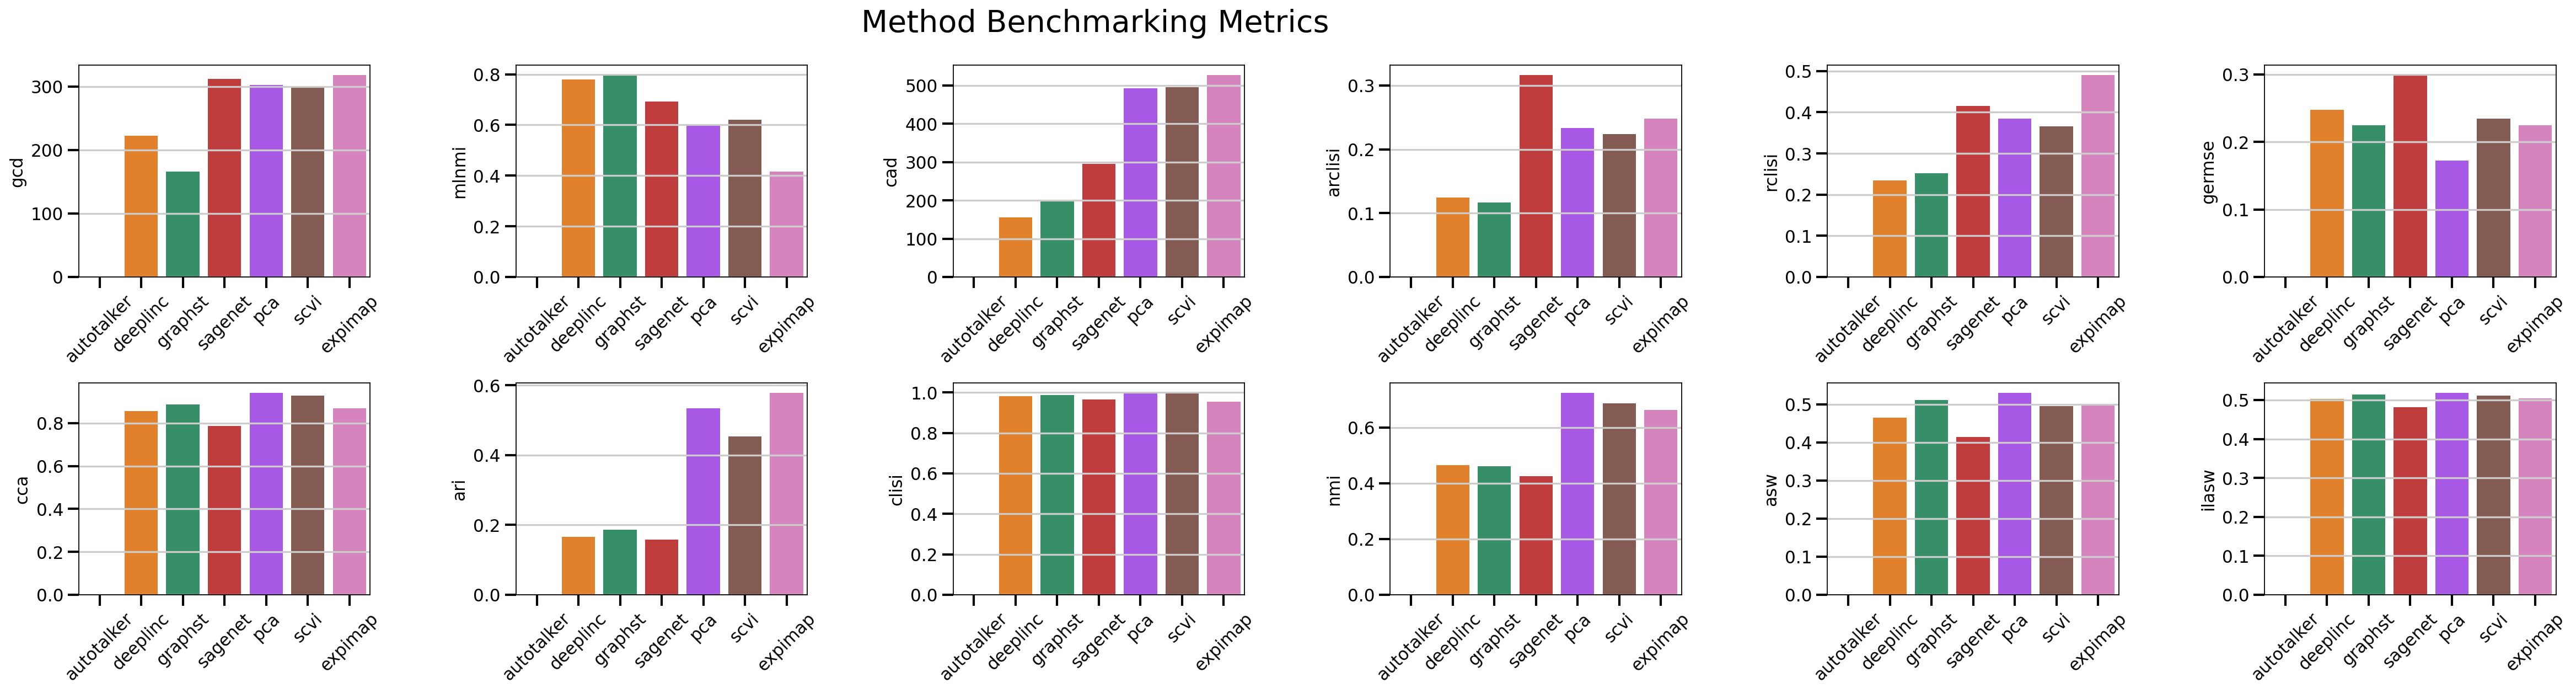

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=int(np.ceil(len(columns)/2)), figsize=(3*len(columns), 8))
axs=axs.flatten()

for i, col in enumerate(columns):
    sns.barplot(data=mean_df, x=mean_df.index, y=col, ax=axs[i])
    axs[i].set_xlabel('')
    xlabels = axs[i].get_xticks()
    axs[i].set_xticklabels(mean_df.index, rotation=45)
plt.suptitle("Method Benchmarking Metrics", fontsize=25)
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.9)

if len(columns) % 2 != 0:
    fig.delaxes(axs[-1])

fig.savefig(f"{figure_folder_path}/metrics_{current_timestamp}.png",
            bbox_inches="tight")    
plt.show()

In [20]:
adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")

In [23]:
adata_pca

AnnData object with n_obs × n_vars = 14185 × 351
    obs: 'Area', 'celltype_mapped_refined', 'sample', 'batch'
    uns: 'X_name', 'celltype_mapped_refined_colors', 'pca_active_gp_names_run1', 'pca_active_gp_names_run10', 'pca_active_gp_names_run2', 'pca_active_gp_names_run3', 'pca_active_gp_names_run4', 'pca_active_gp_names_run5', 'pca_active_gp_names_run6', 'pca_active_gp_names_run7', 'pca_active_gp_names_run8', 'pca_active_gp_names_run9', 'pca_model_training_duration_run1', 'pca_model_training_duration_run10', 'pca_model_training_duration_run2', 'pca_model_training_duration_run3', 'pca_model_training_duration_run4', 'pca_model_training_duration_run5', 'pca_model_training_duration_run6', 'pca_model_training_duration_run7', 'pca_model_training_duration_run8', 'pca_model_training_duration_run9'
    obsm: 'pca_latent_run1', 'pca_latent_run10', 'pca_latent_run2', 'pca_latent_run3', 'pca_latent_run4', 'pca_latent_run5', 'pca_latent_run6', 'pca_latent_run7', 'pca_latent_run8', 'pca_latent_r

In [24]:
        sc.pp.neighbors(adata=adata_pca,
                        use_rep="pca_latent_run1",
                        n_neighbors=4,
                        random_state=0)

In [98]:
row = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
col = np.array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
data = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
con = sp.csr_matrix((data, (row, col)), shape=(4, 4))

In [99]:
row = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
col = np.array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
data = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
con2 = sp.csr_matrix((data, (row, col)), shape=(4, 4))

In [100]:
con.toarray()

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [101]:
con2.toarray()

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

In [102]:
connectivities_diff = con2 - con

In [86]:
import scipy.sparse as sp

In [103]:
    gcd = sp.linalg.norm(connectivities_diff,
                         ord="fro") / connectivities_diff.shape[0]

In [104]:
gcd

1.0

In [111]:
np.log2(1/2)

-1.0

In [108]:
np.log2(12/1)

3.584962500721156

##### 3.2.8.1 Metrics Ranking Plot

In [ ]:
mean_df_min_best = mean_df[["gcd", "cad", "arclisi", "germse"]] # lower values are better
mean_df_max_best = mean_df[["mlnmi", "cca", "ari", "clisi", "nmi", "asw", "ilasw", ]] # higher values are better
rank_df_min = mean_df_min_best.rank(method="max", ascending=True)
rank_df_max = mean_df_max_best.rank(method="max", ascending=False)
rank_df = pd.concat([rank_df_min, rank_df_max], axis=1)
rank_df = rank_df[columns]

In [ ]:
heatmap = sns.heatmap(rank_df, annot=True, cmap="YlGnBu")
fig = heatmap.get_figure()
plt.title("Method Benchmarking Metrics Ranking", fontsize=20, pad=25)
plt.xticks(rotation=45)
fig.savefig(f"{figure_folder_path}/metrics_ranking_{current_timestamp}.png",
            bbox_inches="tight")
plt.show()